# Preparacion de datos 

En esta fase vamos a crear nuevas variables o transformar las existentes para poder dar mejor respuesta a nuestro objetivo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#Automcompletar rápido
%config IPCompleter.greedy=True

import sqlalchemy as sa

## Importacion de datos

In [2]:
con = sa.create_engine("sqlite:///Datos2023/airbnb.db")


In [3]:
df = pd.read_sql("df", con=con)

In [4]:
pd.options.display.max_columns=None
df

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,bedrooms,bathrooms,host_is_superhost,accommodates,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2
0,0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,85.0,5,1,22,1.0,1.0,t,2,1.0,106,4.88,4.86,4.84,6039
1,1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.414760,-3.704180,Entire home/apt,65.0,5,3,0,1.0,1.0,f,2,2.0,172,4.63,4.78,4.90,6144
2,2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31.0,4,2,135,1.0,1.0,f,1,1.0,33,4.58,4.82,4.21,2699
3,3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,94.0,5,1,168,6.0,1.0,f,3,1.0,33,4.91,4.97,5.00,6144
4,4,26825,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,29.0,3,1,295,1.0,1.5,t,1,1.0,196,4.72,4.72,4.73,4595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21382,21382,1046219783290634155,Rental unit in Madrid · ★New · 2 bedrooms · 3 ...,529402573,Usera,Zofío,40.384658,-3.714106,Entire home/apt,120.0,1,56,303,2.0,1.0,f,4,3.0,0,NaN,NaN,NaN,2368
21383,21383,1045519419976898566,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,529402573,Salamanca,Guindalera,40.438832,-3.671323,Entire home/apt,120.0,1,56,189,1.0,1.0,f,2,1.0,0,NaN,NaN,NaN,7374
21384,21384,1046222300986271054,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,31772865,Tetuán,Castillejos,40.458234,-3.695566,Entire home/apt,171.0,1,42,318,1.0,1.0,f,2,1.0,0,NaN,NaN,NaN,4344
21385,21385,1046239141714406672,Rental unit in Madrid · ★New · 2 bedrooms · 4 ...,346367515,Chamberí,Arapiles,40.433040,-3.711060,Entire home/apt,74.0,31,237,326,2.0,1.0,f,4,4.0,0,NaN,NaN,NaN,6347


## Preparacion de variables

### Creacion de KPIs sobre las palancas identificadas

Primero vamos a crear las variables de análisis, es decir las que habíamos identificado como los Kpis que usaremos en las palancas que influyen sobre el negocio.

Habíamos identificado 3 palancas:

* **precio por noche**: La tenemos directamente en la variable price, pero vamos a revisarla para ver que la entendemos bien
* **ocupación**: tenemos availability_365 pero hay que transformarla
* **precio del inmueble**: Tendremos que crearla con variables externas
    

#### Analisis del precio por noche

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Vamos a intentar entenderlo analizando el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Nos quedamos con el distrito centro, que es el que más datos tiene. 

In [5]:
df.neighbourhood_group.value_counts()

neighbourhood_group
Centro                   9324
Salamanca                1463
Chamberí                 1433
Tetuán                   1189
Arganzuela               1016
Carabanchel               760
Retiro                    749
Ciudad Lineal             681
Chamartín                 648
Puente de Vallecas        591
Latina                    576
Usera                     561
Moncloa - Aravaca         514
Hortaleza                 461
San Blas - Canillejas     456
Fuencarral - El Pardo     303
Villaverde                210
Barajas                   146
Moratalaz                 126
Villa de Vallecas         103
Vicálvaro                  77
Name: count, dtype: int64

In [99]:
df.loc[df.neighbourhood_group=="Centro"].groupby("room_type").price.mean()

room_type
Entire home/apt    152.601012
Private room        94.217582
Shared room         95.751351
Studio             101.781250
Name: price, dtype: float64

- Alquilar un apartamento en el centro tiene un precio medio de 147€
- Alquilar una habitación privada y compartida tienen un precio medio de 95€, nos resulta algo extraño por lo que seguimos analizando. 

In [6]:
df.room_type.value_counts()

room_type
Entire home/apt    13208
Private room        6390
Studio              1488
Shared room          301
Name: count, dtype: int64

* Distritos en los que el precio por noche de la habitación compartida es mayor que el precio por habitación privada o por apartamento. 

In [7]:
precio_medio_por_tipo_y_distrito = df.groupby(['neighbourhood_group', 'room_type'])['price'].mean().unstack()

# Filtrar para obtener solo los distritos donde el precio de habitación compartida es mayor que el de habitación privada o apartamento entero
distritos_precio_compartida_mayor_privada = precio_medio_por_tipo_y_distrito[precio_medio_por_tipo_y_distrito['Shared room'] > precio_medio_por_tipo_y_distrito['Private room']]
distritos_precio_compartida_mayor_apartamento = precio_medio_por_tipo_y_distrito[precio_medio_por_tipo_y_distrito['Shared room'] > precio_medio_por_tipo_y_distrito['Entire home/apt']]

# Mostrar los resultados
print("Distritos donde el precio de habitación compartida es mayor que el de habitación privada:")
print(distritos_precio_compartida_mayor_privada)

print("\nDistritos donde el precio de habitación compartida es mayor que el de apartamento entero:")
print(distritos_precio_compartida_mayor_apartamento)


Distritos donde el precio de habitación compartida es mayor que el de habitación privada:
room_type              Entire home/apt  Private room  Shared room      Studio
neighbourhood_group                                                          
Arganzuela                  142.213008     63.403030   295.625000   78.600000
Carabanchel                 110.960894     52.865922    83.600000   73.641026
Centro                      152.601012     94.217582    95.751351  101.781250
Chamartín                   140.797136    118.258883   249.500000  105.100000
Chamberí                    161.430939     86.276744   241.000000   89.777778
Ciudad Lineal               131.371795     90.548589   128.000000  181.675000
Latina                       96.686695     84.405751   264.166667   95.458333
Puente de Vallecas          187.842742     56.552632   534.750000   71.419355
Salamanca                   186.676498     80.467857   166.400000  102.516129
San Blas - Canillejas       234.461957    220.173387

In [8]:
distritos_especificos = ["Arganzuela", "Carabanchel", "Chamartín", "Chamberí","Ciudad Lineal","Latina","Puente de Vallecas","Salamanca","San Blas - Canillejas","Usera","Villa de Vallecas"]

df_filtrado = df[df['neighbourhood_group'].isin(distritos_especificos)]

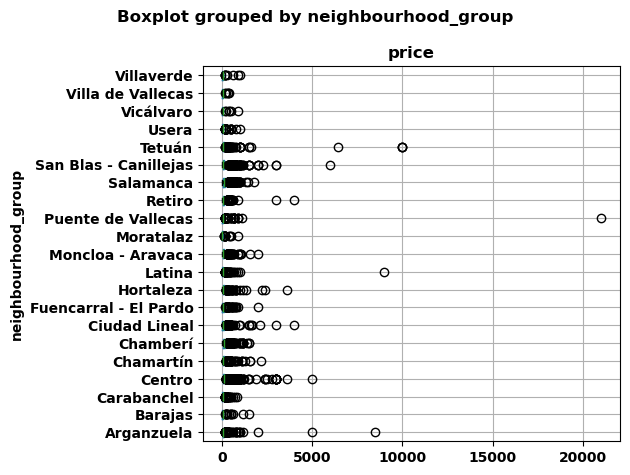

In [9]:
boxplot = df.boxplot(column="price", by="neighbourhood_group", vert=False)

plt.tight_layout()

plt.show()

In [14]:
df_filtrado.loc[(df_filtrado['room_type'] == "Shared room") & (df_filtrado['price'] >100)][["neighbourhood_group", "bedrooms", "price"]]


,neighbourhood_group,bedrooms,price
3808,Ciudad Lineal,1.0,200.0
4833,Chamberí,1.0,200.0
4868,Carabanchel,1.0,250.0
4977,Latina,1.0,900.0
5069,San Blas - Canillejas,1.0,250.0
5190,Chamartín,1.0,450.0
5222,San Blas - Canillejas,1.0,1000.0
5245,Chamberí,1.0,1500.0
5295,Ciudad Lineal,1.0,400.0
5524,Arganzuela,1.0,370.0


In [10]:
df_filtrado.loc[(df_filtrado['room_type'] == "Private room") & (df_filtrado['price'] >1500)][["neighbourhood_group", "bedrooms", "price"]]


,neighbourhood_group,bedrooms,price
2314,Salamanca,1.0,1788.0
4859,Ciudad Lineal,1.0,2100.0
5005,Ciudad Lineal,3.0,1700.0
5009,San Blas - Canillejas,2.0,3000.0
5173,San Blas - Canillejas,3.0,2000.0
9147,Chamartín,1.0,1570.0
9150,Chamartín,1.0,1570.0
11184,Latina,1.0,9000.0
12118,Ciudad Lineal,1.0,4000.0


In [15]:
df = df.loc[~((df['room_type'] == "Shared room") & (df['price'] > 100) & (df["bedrooms"] <= 1))]

In [16]:
df= df.loc[~((df['room_type'] == "Private room") & (df['price'] > 1500) & (df["bedrooms"] <= 1))]

In [17]:
df.groupby(["neighbourhood_group", "room_type"])["price"].mean()

neighbourhood_group  room_type      
Arganzuela           Entire home/apt    142.213008
                     Private room        63.403030
                     Shared room         39.750000
                     Studio              78.600000
Barajas              Entire home/apt    142.022222
                                           ...    
Villa de Vallecas    Studio              76.000000
Villaverde           Entire home/apt     97.547945
                     Private room        62.164062
                     Shared room         33.000000
                     Studio              55.125000
Name: price, Length: 79, dtype: float64

- En algunos distritos, notamos que el precio medio por habitación compartida es significativamente más alto que el precio por habitación privada e incluso por apartamento completo. Este fenómeno puede ser atribuido a datos atípicos, como alquileres con precios muy elevados debido a su ubicación cercana a puntos de interés o eventos.

- Para proseguir con el análisis, procedemos a filtrar los registros donde el precio por noche por habitación compartida en viviendas de una o ninguna habitación sea superior a 100€, así como los registros donde el precio por habitación privada sea superior a 1500€ la noche en viviendas con una o ninguna habitación.

**Calculo del precio total del apartamento por noche**

Multiplicar el precio por el total de habitaciones puede sesgar al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto deberíamos ponderarlo por el porcentaje medio de habitaciones alquiladas.

No tenemos ese dato, pero suponemos que hemos hablado con el responsable de negocio y nos ha dicho que es del 70%.

Creamos la variable precio total aplicando apply sobre una función personalizada.

In [18]:
def precio_total(registro):
    if (registro.bedrooms > 1) & ((registro.room_type == "Private room") | (registro.room_type == "Shared room")):
        result = registro.price * registro.bedrooms * 0.7
    else: 
        result = registro.price
        
    return result

df["precio_total"] = df.apply(precio_total, axis=1)

In [19]:
(df[["name","neighbourhood_group", "room_type", "price", "bedrooms", "precio_total"]]
.loc[df.room_type != "Entire home/apt"].head(20))

,name,neighbourhood_group,room_type,price,bedrooms,precio_total
0,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,Chamartín,Private room,85.0,1.0,85.0
2,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,Latina,Private room,31.0,1.0,31.0
4,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,Arganzuela,Private room,29.0,1.0,29.0
11,Rental unit in Madrid · ★4.60 · 1 bedroom · 2 ...,Centro,Private room,73.0,1.0,73.0
16,Rental unit in Madrid · ★4.55 · 1 bedroom · 1 ...,Centro,Private room,49.0,1.0,49.0
19,Rental unit in Madrid · ★4.42 · Studio · 1 bed...,Centro,Studio,67.0,1.0,67.0
20,Rental unit in Madrid · ★4.66 · 1 bedroom · 1 ...,Arganzuela,Private room,33.0,1.0,33.0
28,Rental unit in Madrid · ★4.96 · 1 bedroom · 2 ...,Salamanca,Private room,29.0,1.0,29.0
29,Rental unit in Madrid · ★4.57 · Studio · 1 bed...,Centro,Studio,80.0,1.0,80.0
33,Rental unit in Madrid · ★4.75 · Studio · 2 bed...,Centro,Studio,129.0,1.0,129.0


### Analisis de la variable ocupación

In [20]:
df.availability_365.head()

0     22
1      0
2    135
3    168
4    295
Name: availability_365, dtype: int64

In [21]:
df["ocupacion"] = (((365 - df.availability_365) / 365)*100).astype("float").round(1)

In [22]:
df[["availability_365", "ocupacion"]]

,availability_365,ocupacion
0,22,94.0
1,0,100.0
2,135,63.0
3,168,54.0
4,295,19.2
...,...,...
21382,303,17.0
21383,189,48.2
21384,318,12.9
21385,326,10.7


## Transfomarcion de variables de analisis

Normalmente podremos hacer mejor estos análisis si discretizamos la variable de análisis.

En nuestro caso las candidatas para este análisis son: accommodates, bedrooms, beds y number_of_reviews.

En bedrooms tiene sentido una discretización más personalizada. En las otras podemos hacerla automática.

**Discretizar Bedrooms**

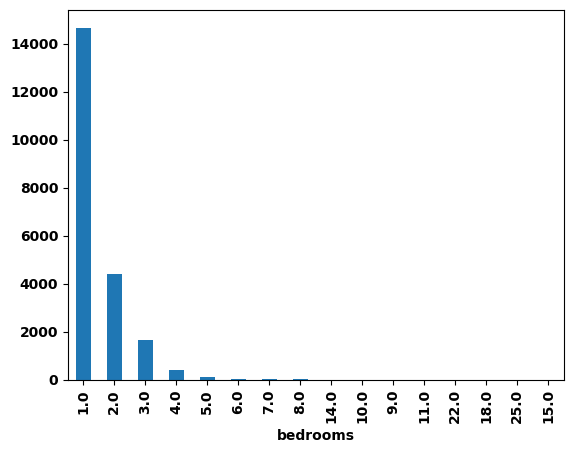

In [23]:
df.bedrooms.value_counts().plot.bar();

In [24]:
condiciones = [df.bedrooms ==1, 
               df.bedrooms ==2, 
               df.bedrooms ==3, 
               df.bedrooms >=4]

resultados = ["01_Una", "02_Dos", "03_Tres", "04_Cuatro_o_mas"]

df["bedrooms_disc"] = np.select(condiciones, resultados, default=-999)

**Discetizar Accommodates**

Pasándole los percentiles: 
- df[var1_disc’] = pd.qcut(df['var1 '], [0, 0.5,1]))

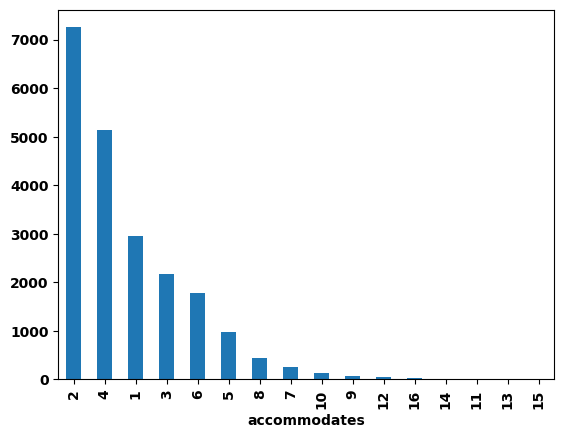

In [25]:
df.accommodates.value_counts().plot.bar();

<Axes: xlabel='accommodates'>

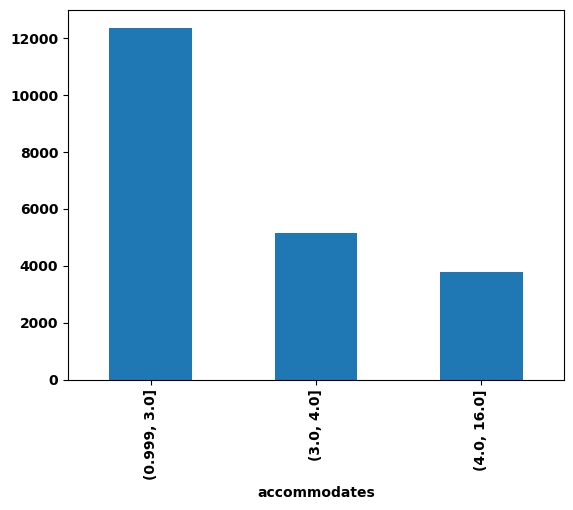

In [26]:
pd.qcut(df["accommodates"], [0, 0.5, 0.8, 1]).value_counts().plot.bar()

In [27]:
df["accommodates_disc"] = pd.qcut(df["accommodates"], [0, 0.5, 0.8, 1], 
       labels = ['0-3','4','5-16'])

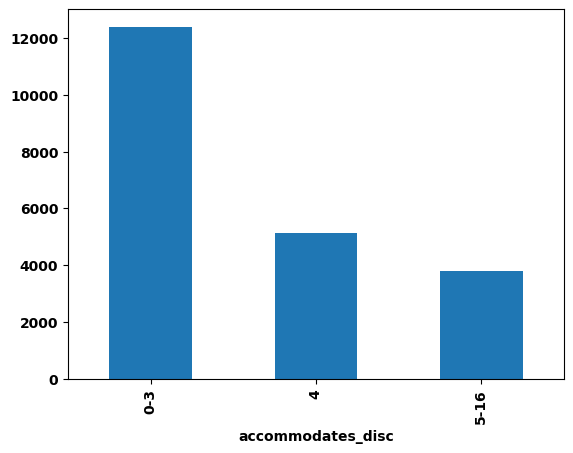

In [28]:
df.accommodates_disc.value_counts().plot.bar();

**Discretizar beds**

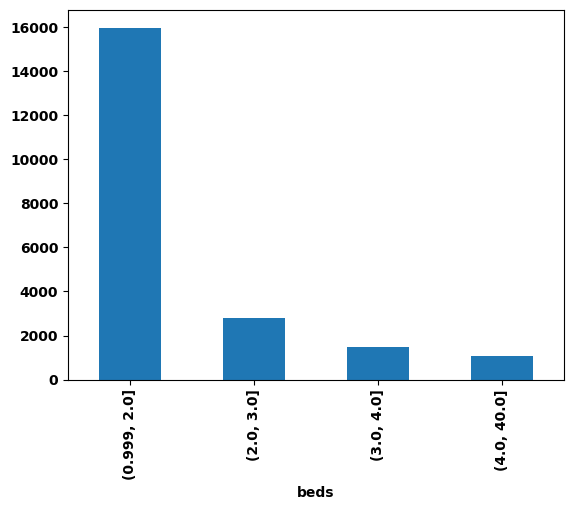

In [29]:
pd.qcut(df["beds"], [0, 0.25,0.5, 0.75, 0.9, 1], duplicates="drop").value_counts().plot.bar();

In [30]:
df["beds_disc"] = pd.qcut(df["beds"], [0, 0.25,0.5, 0.75, 0.9, 1],
        duplicates="drop",
       labels = ['1','2','3','4-39'])

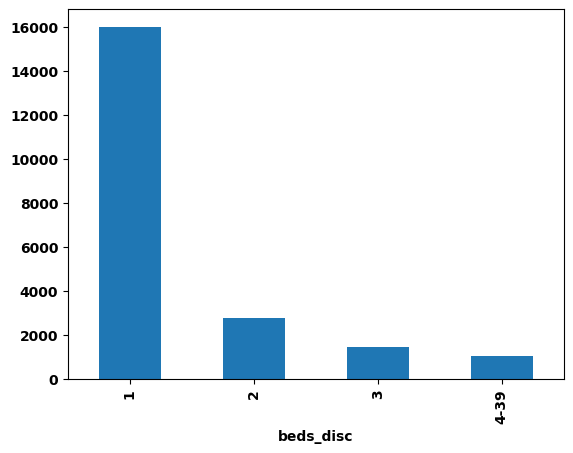

In [31]:
df.beds_disc.value_counts().plot.bar();

**Discretizar number_of_reviews**

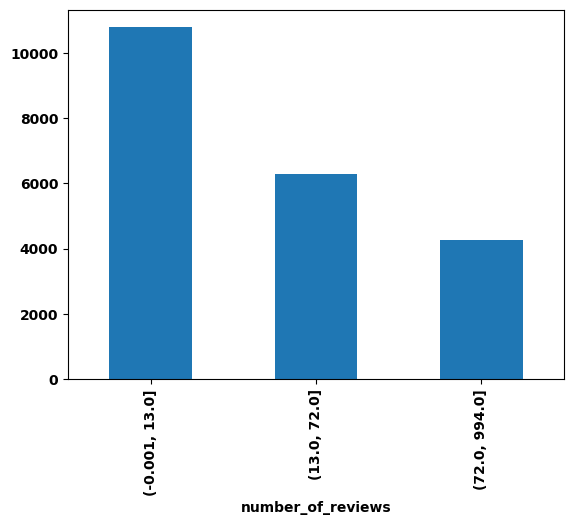

In [32]:
pd.qcut(df["number_of_reviews"], [0, 0.5, 0.8, 1]).value_counts().plot.bar();

In [33]:
df["number_of_reviews_disc"] = pd.qcut(df["number_of_reviews"], [0, 0.5, 0.8, 1], 
       labels = ['0-5','6-29','30-297'])

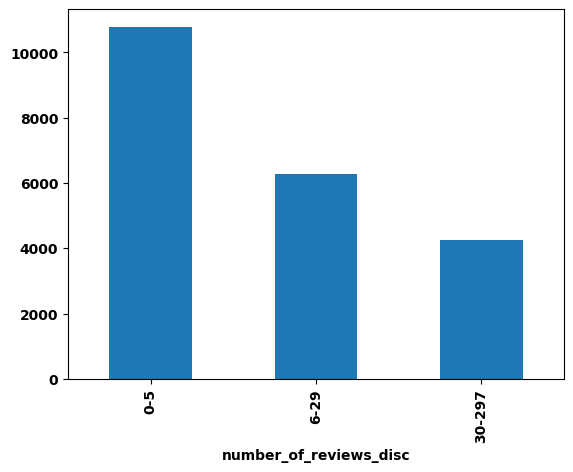

In [34]:
df.number_of_reviews_disc.value_counts().plot.bar();

**Discretizar Ocupación**

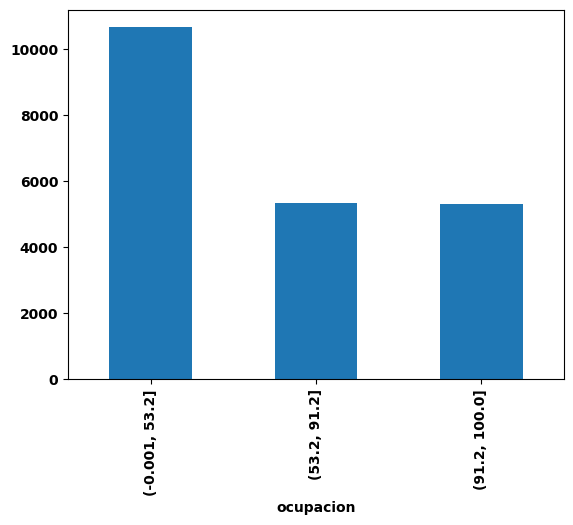

In [35]:
pd.qcut(df["ocupacion"], [0,0.5, 0.75, 1],
        duplicates="drop").value_counts().sort_values(ascending=False).plot.bar();

In [36]:
df["ocupacion_disc"] = pd.qcut(df["ocupacion"], [0, 0.5, 0.75, 1], 
       labels = ['00_0%-52%','01_53%-90%','02_91%-100%'])

## Creacion de variables con datos externos

- Estimacion del precio del inmueble

Para ello necesitamos estimar los metros cuadrados que tiene cada vivienda, ya que el precio por metro cuadrado ya lo tenemos cargado en nuestra base de datos obtenido de idealista

In [38]:
pd.crosstab(df.bathrooms, df.bedrooms)

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,14.0,15.0,18.0,22.0,25.0
bathrooms,,,,,,,,,,,,,,,,
0.0,130,7,3,0,0,0,0,1,0,0,0,0,0,0,0,0
0.5,119,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1.0,12095,2394,445,55,8,2,3,4,1,1,1,1,0,0,1,1
1.5,1114,231,83,20,1,0,0,0,0,0,0,0,0,1,0,0
2.0,853,1653,817,151,43,11,1,1,0,0,0,0,0,0,0,0
2.5,94,73,73,23,5,0,0,1,0,0,0,0,0,0,0,0
3.0,170,43,206,81,24,0,3,0,0,0,0,0,0,0,0,0
3.5,7,1,22,16,2,0,0,0,0,0,0,0,0,0,0,0
4.0,42,1,12,37,15,4,2,2,0,0,0,0,0,0,0,0


- viviendas de 0 a 2 habitaciones: el valor mas comun es un baño
- viviendas de 3 a 6 habitaciones: el valor mas comun son 2 baños
- Viviendas de 7 habitaciones: El valor mas comun son 3 baños 

Estimación de los metros cuadrados del inmueble

Vamos usar el siguiente algoritmo:

- una habitación: m2 = 60
- dos habitaciones: m2 = 70
- tres habitaciones: m2 = 90
- cuatro habitaciones: m2 = 120
- cinco o más habitaciones: m2 = 150

In [39]:
condiciones = [df.bedrooms==1, 
              df.bedrooms==2, 
              df.bedrooms==3, 
              df.bedrooms==4, 
              df.bedrooms>4]
resultados = [60,70,90,120,150]

df["metros_2"] = np.select(condiciones, resultados, default=-999)

In [40]:
df.metros_2.value_counts()

metros_2
60     14667
70      4406
90      1664
120      394
150      188
Name: count, dtype: int64

In [41]:
df["precio_compra"] = df.metros_2 * df.precio_m2

In [42]:
df.columns

Index(['index', 'id', 'name', 'host_id', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'calculated_host_listings_count', 'availability_365',
       'bedrooms', 'bathrooms', 'host_is_superhost', 'accommodates', 'beds',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_communication', 'review_scores_location', 'precio_m2',
       'precio_total', 'ocupacion', 'bedrooms_disc', 'accommodates_disc',
       'beds_disc', 'number_of_reviews_disc', 'ocupacion_disc', 'metros_2',
       'precio_compra'],
      dtype='object')

In [43]:
(df[["name","neighbourhood_group", "room_type", "price", 
    "bedrooms", "bathrooms","precio_m2", "metros_2", "precio_compra"]].head(20))

,name,neighbourhood_group,room_type,price,bedrooms,bathrooms,precio_m2,metros_2,precio_compra
0,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,Chamartín,Private room,85.0,1.0,1.0,6039,60,362340
1,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,Centro,Entire home/apt,65.0,1.0,1.0,6144,60,368640
2,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,Latina,Private room,31.0,1.0,1.0,2699,60,161940
3,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,Centro,Entire home/apt,94.0,6.0,1.0,6144,150,921600
4,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,Arganzuela,Private room,29.0,1.0,1.5,4595,60,275700
5,Rental unit in Madrid · ★4.63 · 2 bedrooms · 3...,Centro,Entire home/apt,90.0,2.0,1.0,6144,70,430080
6,Rental unit in Madrid · ★4.61 · 1 bedroom · 2 ...,Centro,Entire home/apt,106.0,1.0,1.0,6144,60,368640
7,Rental unit in Madrid · ★4.65 · 1 bedroom · 3 ...,Centro,Entire home/apt,90.0,1.0,1.0,6144,60,368640
8,Rental unit in Madrid · ★4.89 · 1 bedroom · 2 ...,Centro,Entire home/apt,65.0,1.0,1.0,6144,60,368640
9,Rental unit in Madrid · ★4.88 · 1 bedroom · 2 ...,Centro,Entire home/apt,99.0,1.0,1.0,6144,60,368640


Al disponer de las variables x, y de la localización de cada inmueble, nos permite calcular distancias con puntos de interés de la ciudad de Madrid. 

Vamos a calcular la distancia de cada inmueble a la Puerta del Sol.

Para ello buscamos en Google su longitud y latitud: https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitud: 40.4167278 Longitud: -3.7033387

**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

En el siguiente enlace encontramos una fórmula para calcular este tipo de distancias que adaptamos a nuestros datos. 
https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [44]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [45]:
lat1 = 40.4167278
lon1 = -3.7033387

In [46]:
df["distancia_a_sol"] = df.apply(lambda registro: haversine(lat1, lon1, registro.latitude, registro.longitude), axis=1)

In [47]:
df.groupby("neighbourhood_group")["distancia_a_sol"].mean().sort_values()

neighbourhood_group
Centro                    0.723035
Arganzuela                1.912483
Chamberí                  2.132681
Retiro                    2.464352
Salamanca                 2.765321
Moncloa - Aravaca         3.426964
Latina                    3.765169
Carabanchel               3.855666
Usera                     3.954145
Puente de Vallecas        4.520202
Chamartín                 4.581853
Tetuán                    4.705894
Moratalaz                 5.017935
Ciudad Lineal             5.148085
Villaverde                7.645335
Fuencarral - El Pardo     7.953007
Hortaleza                 8.002169
San Blas - Canillejas     8.297441
Villa de Vallecas         9.315375
Vicálvaro                 9.371527
Barajas                  11.487938
Name: distancia_a_sol, dtype: float64

## Guardar el dataset en la base de datos 

In [48]:
df.to_sql("df_analisis", con, if_exists="replace")

21319